# Blind quantum machine learning based on quantum circuit model

复现作者：周旭

华为云账号：hw33393305

邮箱地址：zhouxu39@huawei.com

## 项目介绍

### 文章基本信息

我要复现的是2021年11月1日在《Quantum Information Processing》上发表的论文，文章题目为“Blind quantum machine learning based on quantum circuit model”，文章作者为Xu Zhou和Daowen Qiu。

### 文章摘要

Blind quantum machine learning (BQML) is a novel secure quantum computation protocol that enables a client (Alice), who has limited quantum technology at her disposal, to delegate her quantum machine learning to a remote quantum server (Bob) who owns a fully-fledged quantum computer and promises to execute the learning task honestly, in such a way that Bob cannot obtain Alice's private information. In this paper, we first propose the concept of BQML that combines blind quantum computation and quantum machine learning and we devise two BQML protocols based on quantum circuit model in which Alice can classify vectors of any dimension to different clusters. The first protocol is half-blind, while the second is blind. It means Alice's privacy can be protected. On the other hand, Alice is only required to possess a quantum random access memory (QRAM), apply the Pauli operators ($X$ and $Z$), store, send, receive qubits and perform measurements in our protocols. Finally, we analyze the security, blindness and correctness of our protocols, and give a brief conclusion.

### 文章的主要思路

（1）考虑机器学习中一个实际任务————将向量分类到不同的簇；

（2）根据“similarity measure”将一个新向量分类$\vec{u}$分到簇$A$或者簇$B$，而“similarity measure”的其中一个度量就是计算两个向量的欧几里得距离；

（3）计算两个向量的欧几里得距离可以转化成求这两个向量的内积；

（4）当向量的维度很高的时候，经典计算机计算两个向量的内积将是一个很棘手的问题，然而通过量子计算中的Swap Test却能很高效地计算该任务；

（5）未来量子计算机的应用将会以“云”的模式被用户使用，因此客户需要分发自己的量子机器学习任务给量子计算服务器，同时保护自己数据的隐私；

（6）根据分别计算得到的$D_A = \| \vec{u} - \vec{v_A} \|$和$D_B = \| \vec{u} - \vec{v_B} \|$，将$u$分到距离更小的一簇，其中$\vec{v_A}$和$\vec{v_B}$分别是簇$A$和簇$B$的参考向量。

### 文章的三个假设

（1）文章中的提到的向量都是实且非负的；

（2）文章中的量子信道都是理想信道，即没有误差；

（3）客户Alice拥有基本的量子能力：拥有QRAM（制备向量对应的量子态），可以执行$X$和$Z$操作，储存、发送、接收和测量量子比特。

### 复现目标

我将通过MindQuantum验证：

（1）论文中的Fig1可以计算2个2维向量$\vec{u}$和$\vec{v}$的欧几里得距离；

（2）论文中的Fig2-Fig6和Fig9（`H` gate, `Fredkin` gate, `CNOT` gate, `CZ` gate, `SWAP` gate，`Toffoli` gate）的线路正确性；

（3）论文中的Fig7可以计算2个16维向量$\vec{u}$和$\vec{v}$的欧几里得距离（即$n=4$的情况）；

（4）论文中的Fig8和Fig10的线路等价性；

（5）论文中的Fig11的线路正确性；

（6）论文中的Fig12（$n=4$的情况），即在Fig7的基础上保密计算2个16维向量$\vec{u}$和$\vec{v}$的欧几里得距离。

## 复现过程

下面，我将根据复现目标，通过MindQuantum复现该文章的主要结果。

### 环境准备，导入模拟器所需要的包。

In [1]:
from mindquantum import *
import numpy as np
from numpy import random

[WARNING] ME(828455:140613216904512,MainProcess):2023-10-17-18:54:53.543.43 [mindspore/run_check/_check_version.py:102] MindSpore version 2.1.0 and cuda version 11.8.89 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.


### 通过MindQuantum验证（1）论文中的Fig1可以计算2个2维向量$\vec{u}$和$\vec{v}$的欧几里得距离；

首先，文中提到，任意向量可以表示成$\vec{x} = \|\vec{x}\||x\rangle$，那么2维向量$\vec{u}$和$\vec{v}$的欧几里得距离的计算如下：


\begin{eqnarray}
  D &=& \|\vec{u}-\vec{v}\| = \|\|\vec{u}\||u\rangle-\|\vec{v}\||v\rangle\| \nonumber \\
    &=& \sqrt{(\|\vec{u}\|\langle u|-\|\vec{v}\|\langle v|)\cdot(\|\vec{u}\||u\rangle-\|\vec{v}\||v\rangle)} \nonumber \\
    &=&  \sqrt{\|\vec{u}\|^2 + \|\vec{v}\|^2 - 2\|\vec{u}\|\|\vec{v}\|\langle u|v\rangle}.
\end{eqnarray}

因此，计算两个向量的欧几里得距离可以转化成求这两个向量的内积（因为模长和对应的量子态可以通过QRAM得到）。

我将通过具体的例子来验证。

首先，随机生成2个实且非负的2维向量$\vec{u}$和$\vec{v}$，然后，计算向量$\vec{u}$和$\vec{v}$对应的量子态$|u\rangle$和$|v\rangle$的$\langle u|v\rangle$，最后得到期望得到的欧几里得距离。

In [2]:
# 为了便于复现，设定生成随机数的种子
random.seed(9)

# 随机生成两个实且非负的2维向量u和v
# random.randint(0, 11, 2)可以返回2个[0,10]之间的任意整数
u = random.randint(0, 11, 2)
v = random.randint(0, 11, 2)

print("向量u为", u, "，向量v为", v)

向量u为 [5 6] ，向量v为 [8 6]


In [3]:
# 分别求出向量u和向量v的模长
length_u = np.sqrt(u[0]**2 + u[1]**2)
length_v = np.sqrt(v[0]**2 + v[1]**2)

print("向量u的模长为", length_u, "，向量v的模长为", length_v)

向量u的模长为 7.810249675906654 ，向量v的模长为 10.0


In [4]:
# 根据向量u和向量v的模长，将它们进行归一化处理
u_nor = u / length_u
v_nor = v / length_v

print("归一化后的向量u为", u_nor, "，归一化后的向量v为", v_nor)

归一化后的向量u为 [0.6401844  0.76822128] ，归一化后的向量v为 [0.8 0.6]


In [5]:
# 两个归一化向量的内积
inner_product = np.dot(v_nor, u_nor)

print("归一化后的向量u和向量v的内积等于", inner_product)

归一化后的向量u和向量v的内积等于 0.9730802874900095


In [6]:
# 向量u和向量v的欧几里得距离
D_Euc = np.sqrt(length_u**2 + length_v**2 - 2 * length_u * length_v * inner_product)

print("向量u和向量v的欧几里得距离等于", D_Euc)

向量u和向量v的欧几里得距离等于 3.0


通过经典计算的方法，我们可以得到向量$\vec{u}$和$\vec{v}$的欧几里得距离$D_{Euc}=3$。

下面我们尝试用量子计算的方法来计算，即复现论文中的Fig1。

![Fig_1.png](./Fig_1.png)

- 第一步：初态制备

In [7]:
# 归一化的向量u和向量v的张量积
# 注意，越靠上的量子比特，做张量积的时候越靠右，因为MindQuantum的读取顺序是从右往左
pre = np.kron(v_nor, u_nor)

print("归一化后的向量u和向量v的张量积为", pre)

归一化后的向量u和向量v的张量积为 [0.51214752 0.61457702 0.38411064 0.46093277]


In [8]:
# |0>态对应的向量
state_0 = np.array([1, 0])

print("|0>态对应的向量为", state_0)

|0>态对应的向量为 [1 0]


In [9]:
# 制备初态
initial_state = np.kron(pre, state_0)

print("初态对应的向量为", initial_state)

初态对应的向量为 [0.51214752 0.         0.61457702 0.         0.38411064 0.
 0.46093277 0.        ]


In [10]:
sim = Simulator('mqvector', 3)  # 调用一个3量子比特的模拟器
sim.set_qs(initial_state)       # 将模拟器的初态设为与initial_state对应的量子态

print(sim.get_qs(True))         # 打印我们制备好的初态

0.512147519731584¦000⟩
0.6145770236779007¦010⟩
0.3841106397986879¦100⟩
0.4609327677584255¦110⟩


- 第二步：SWAP Test

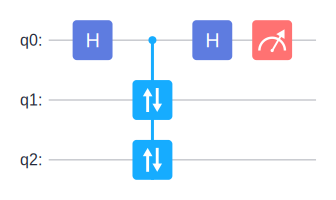

In [11]:
# 搭建SWAP Test线路模型
cir_SWAP_Test = Circuit()
cir_SWAP_Test += H.on(0)
cir_SWAP_Test += SWAP.on([1, 2], 0)
cir_SWAP_Test += H.on(0)
cir_SWAP_Test += Measure().on(0)
cir_SWAP_Test.svg()

- 第三步：测量

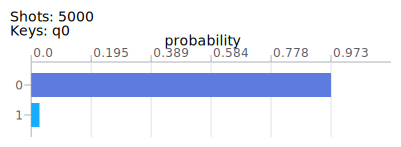

In [12]:
res = sim.sampling(cir_SWAP_Test, shots=5000)
res.svg()

- 第四步：统计结果，得到欧几里得距离

In [13]:
p_0_fig1 = 4870 / 5000
inner_product_ST = np.sqrt(2 * p_0_fig1 - 1)

print("Fig1中测量第一个量子比特，得到测量为0的频率为：", p_0_fig1)
print("通过Fig1得到的内积<u|v>为：", inner_product_ST)

Fig1中测量第一个量子比特，得到测量为0的频率为： 0.974
通过Fig1得到的内积<u|v>为： 0.9736529155710468


In [14]:
error_inner = (inner_product_ST - inner_product) / inner_product * 100

print("通过量子计算的方法计算得到的内积的误差为：", error_inner, "%")

通过量子计算的方法计算得到的内积的误差为： 0.058846951109693145 %


In [15]:
D_Euc_ST = np.sqrt(length_u**2 + length_v**2 - 2 * length_u * length_v * inner_product_ST)

print("向量u和向量v的欧几里得距离等于", D_Euc_ST)

向量u和向量v的欧几里得距离等于 2.98505487961499


In [16]:
error_D_Euc = (D_Euc_ST - D_Euc) / D_Euc * 100

print("通过量子计算的方法计算得到的欧几里得的误差为：", error_D_Euc, "%")

通过量子计算的方法计算得到的欧几里得的误差为： -0.49817067950033156 %


至此，我们通过MindQuantum成功验证（1）论文中的Fig1可以计算2个2维向量$\vec{u}$和$\vec{v}$的欧几里得距离。

### 通过MindQuantum验证（2）论文中的Fig2-Fig6和Fig9（`H` gate, `Fredkin` gate, `CNOT` gate, `CZ` gate, `SWAP` gate，`Toffoli` gate）的线路正确性；

根据文章的介绍，我们分别定义了`H` gate, `Fredkin` gate, `CNOT` gate, `CZ` gate, `SWAP` gate，`Toffoli` gate的随机量子线路，现将我们定义好的相关函数导入：

In [17]:
from src.main import H_encoder, Fredkin_encoder, CNOT_encoder, CZ_encoder, SWAP_encoder, Toffoli_encoder, Toffoli_encoder_fig11

接下来，我们依次复现Fig2-Fig6和Fig9，并验证线路正确性。

![Fig_2.png](./Fig_2.png)

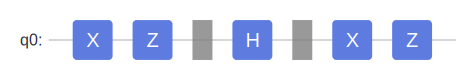

In [18]:
# 为了便于复现，设定生成随机数的种子10，展示随机数全为1的情况，实际过程可以去掉该种子设定
random.seed(10)

H_encoder(0).svg()

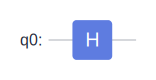

In [19]:
# 搭建一个包含H门的量子线路
circuit_H = Circuit()
circuit_H += H.on(0)
circuit_H.svg()

In [20]:
# 验证上述两个量子线路等价
random.seed(10)

if np.allclose(H_encoder(0).matrix(), circuit_H.matrix()) == True:
    print("上述两个量子线路等价")
else:
    print("上述两个量子线路不等")

上述两个量子线路等价


更一般地，验证`H_encoder(0)`的量子线路与包含`H`门的量子线路的等价性。

In [21]:
# 初始化变量
verify_H = 0

# 重复验证100次
for i in range(100):
    # H_encoder(0)没有设定seed，因此每次产生的随机数都不一样
    if np.allclose(H_encoder(0).matrix(), circuit_H.matrix()) == True:
        verify_H += 1
    else:
        verify_H += 0

if verify_H == 100:
    print("H_encoder(0)的量子线路与包含H门的量子线路等价")
else:
    print("H_encoder(0)的量子线路与包含H门的量子线路不等")

H_encoder(0)的量子线路与包含H门的量子线路等价


也就是说，我们通过MindQuantum成功复现Fig2，并验证该线路的正确性。

![Fig_3.png](./Fig_3.png)

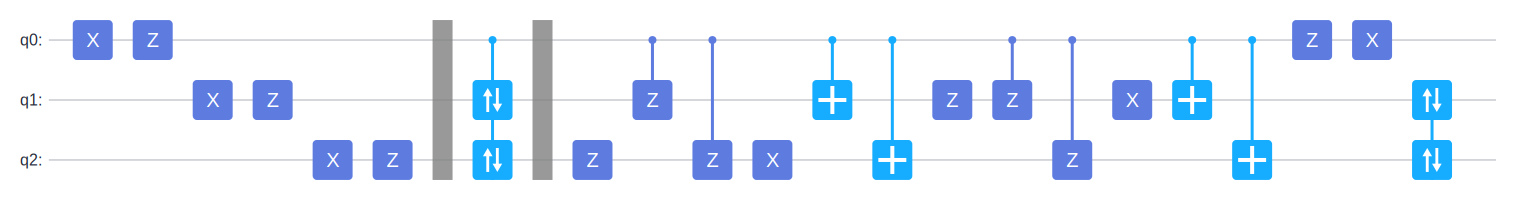

In [22]:
# 为了便于复现，设定生成随机数的种子53，展示随机数全为1的情况，实际过程可以去掉该种子设定
random.seed(53)

Fredkin_encoder([1, 2], 0).svg()

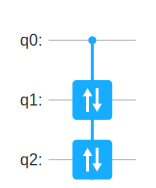

In [23]:
# 搭建一个包含Fredkin门的量子线路
circuit_Fredkin = Circuit()
circuit_Fredkin += SWAP.on([1, 2], 0)
circuit_Fredkin.svg()

In [24]:
# 验证上述两个量子线路等价
random.seed(53)

if np.allclose(Fredkin_encoder([1, 2], 0).matrix(), circuit_Fredkin.matrix()) == True:
    print("上述两个量子线路等价")
else:
    print("上述两个量子线路不等")

上述两个量子线路等价


更一般地，验证`Fredkin_encoder([1, 2], 0)`的量子线路与包含`Fredkin`门的量子线路的等价性。

In [25]:
# 初始化变量
verify_Fredkin = 0

# 重复验证100次
for i in range(100):
    # Fredkin_encoder([1, 2], 0)没有设定seed，因此每次产生的随机数都不一样
    if np.allclose(Fredkin_encoder([1, 2], 0).matrix(), circuit_Fredkin.matrix()) == True:
        verify_Fredkin += 1
    else:
        verify_Fredkin += 0

if verify_Fredkin == 100:
    print("Fredkin_encoder([1, 2], 0)的量子线路与包含Fredkin门的量子线路等价")
else:
    print("Fredkin_encoder([1, 2], 0)的量子线路与包含Fredkin门的量子线路不等")

Fredkin_encoder([1, 2], 0)的量子线路与包含Fredkin门的量子线路等价


也就是说，我们通过MindQuantum成功复现Fig3，并验证该线路的正确性。

![Fig_4.png](./Fig_4.png)

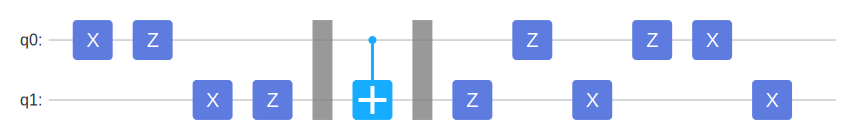

In [26]:
# 为了便于复现，设定生成随机数的种子30，展示随机数全为1的情况，实际过程可以去掉该种子设定
random.seed(30)

CNOT_encoder(1, 0).svg()

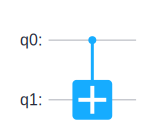

In [27]:
# 搭建一个包含CNOT门的量子线路
circuit_CNOT = Circuit()
circuit_CNOT += X.on(1, 0)
circuit_CNOT.svg()

In [28]:
# 验证上述两个量子线路等价
random.seed(30)

if np.allclose(CNOT_encoder(1, 0).matrix(), circuit_CNOT.matrix()) == True:
    print("上述两个量子线路等价")
else:
    print("上述两个量子线路不等")

上述两个量子线路等价


更一般地，验证`CNOT_encoder(1, 0)`的量子线路与包含`CNOT`门的量子线路的等价性。

In [29]:
# 初始化变量
verify_CNOT = 0

# 重复验证100次
for i in range(100):
    # CNOT_encoder(1, 0)没有设定seed，因此每次产生的随机数都不一样
    if np.allclose(CNOT_encoder(1, 0).matrix(), circuit_CNOT.matrix()) == True:
        verify_CNOT += 1
    else:
        verify_CNOT += 0

if verify_CNOT == 100:
    print("CNOT_encoder(1, 0)的量子线路与包含CNOT门的量子线路等价")
else:
    print("CNOT_encoder(1, 0)的量子线路与包含CNOT门的量子线路不等")

CNOT_encoder(1, 0)的量子线路与包含CNOT门的量子线路等价


也就是说，我们通过MindQuantum成功复现Fig4，并验证该线路的正确性。

![Fig_5.png](./Fig_5.png)

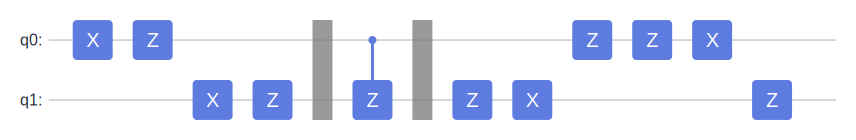

In [30]:
# 为了便于复现，设定生成随机数的种子30，展示随机数全为1的情况，实际过程可以去掉该种子设定
random.seed(30)

CZ_encoder(1, 0).svg()

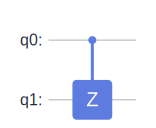

In [31]:
# 搭建一个包含CZ门的量子线路
circuit_CZ = Circuit()
circuit_CZ += Z.on(1, 0)
circuit_CZ.svg()

In [32]:
# 验证上述两个量子线路等价
random.seed(30)

if np.allclose(CZ_encoder(1, 0).matrix(), circuit_CZ.matrix()) == True:
    print("上述两个量子线路等价")
else:
    print("上述两个量子线路不等")

上述两个量子线路等价


更一般地，验证`CZ_encoder(1, 0)`的量子线路与包含`CZ`门的量子线路的等价性。

In [33]:
# 初始化变量
verify_CZ = 0

# 重复验证100次
for i in range(100):
    # CZ_encoder(1, 0)没有设定seed，因此每次产生的随机数都不一样
    if np.allclose(CZ_encoder(1, 0).matrix(), circuit_CZ.matrix()) == True:
        verify_CZ += 1
    else:
        verify_CZ += 0

if verify_CZ == 100:
    print("CZ_encoder(1, 0)的量子线路与包含CZ门的量子线路等价")
else:
    print("CZ_encoder(1, 0)的量子线路与包含CZ门的量子线路不等")

CZ_encoder(1, 0)的量子线路与包含CZ门的量子线路等价


也就是说，我们通过MindQuantum成功复现Fig5，并验证该线路的正确性。

![Fig_6.png](./Fig_6.png)

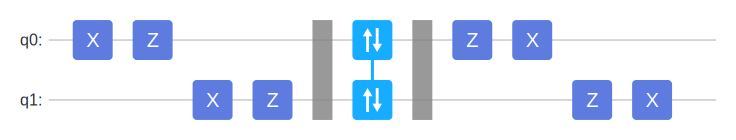

In [34]:
# 为了便于复现，设定生成随机数的种子30，展示随机数全为1的情况，实际过程可以去掉该种子设定
random.seed(30)

SWAP_encoder(1, 0).svg()

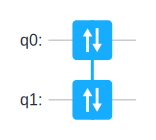

In [35]:
# 搭建一个包含SWAP门的量子线路
circuit_SWAP = Circuit()
circuit_SWAP += SWAP.on([0, 1])
circuit_SWAP.svg()

In [36]:
# 验证上述两个量子线路等价
random.seed(30)

if np.allclose(SWAP_encoder(1, 0).matrix(), circuit_SWAP.matrix()) == True:
    print("上述两个量子线路等价")
else:
    print("上述两个量子线路不等")

上述两个量子线路等价


更一般地，验证`SWAP_encoder(1, 0)`的量子线路与包含`SWAP`门的量子线路的等价性。

In [37]:
# 初始化变量
verify_SWAP = 0

# 重复验证100次
for i in range(100):
    # SWAP_encoder(1, 0)没有设定seed，因此每次产生的随机数都不一样
    if np.allclose(SWAP_encoder(1, 0).matrix(), circuit_SWAP.matrix()) == True:
        verify_SWAP += 1
    else:
        verify_SWAP += 0

if verify_SWAP == 100:
    print("SWAP_encoder(1, 0)的量子线路与包含SWAP门的量子线路等价")
else:
    print("SWAP_encoder(1, 0)的量子线路与包含SWAP门的量子线路不等")

SWAP_encoder(1, 0)的量子线路与包含SWAP门的量子线路等价


也就是说，我们通过MindQuantum成功复现Fig6，并验证该线路的正确性。

![Fig_9.png](./Fig_9.png)

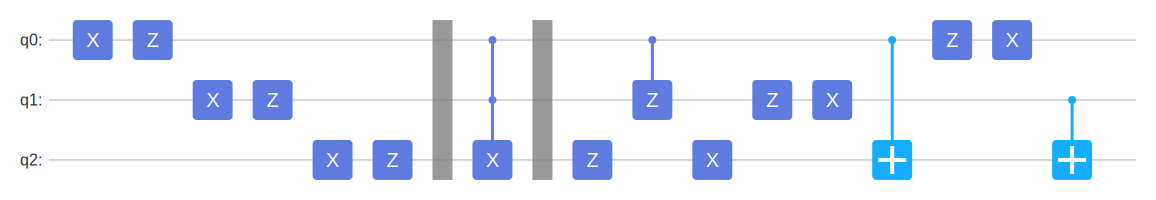

In [38]:
# 为了便于复现，设定生成随机数的种子30，展示随机数全为1的情况，实际过程可以去掉该种子设定
random.seed(53)

Toffoli_encoder(2, [0, 1]).svg()

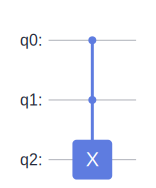

In [39]:
# 搭建一个包含Toffoli门的量子线路
circuit_Toffoli = Circuit()
circuit_Toffoli += X.on(2, [0, 1])
circuit_Toffoli.svg()

In [40]:
# 验证上述两个量子线路等价
random.seed(53)

if np.allclose(Toffoli_encoder(2, [0, 1]).matrix(), circuit_Toffoli.matrix()) == True:
    print("上述两个量子线路等价")
else:
    print("上述两个量子线路不等")

上述两个量子线路等价


更一般地，验证`Toffoli_encoder(2, [0, 1])`的量子线路与包含`Toffoli`门的量子线路的等价性。

In [41]:
# 初始化变量
verify_Toffoli = 0

# 重复验证100次
for i in range(100):
    # Toffoli_encoder(2, [0, 1])没有设定seed，因此每次产生的随机数都不一样
    if np.allclose(Toffoli_encoder(2, [0, 1]).matrix(), circuit_Toffoli.matrix()) == True:
        verify_Toffoli += 1
    else:
        verify_Toffoli += 0

if verify_Toffoli == 100:
    print("Toffoli_encoder(2, [0, 1])的量子线路与包含Toffoli门的量子线路等价")
else:
    print("Toffoli_encoder(2, [0, 1])的量子线路与包含Toffoli门的量子线路不等")

Toffoli_encoder(2, [0, 1])的量子线路与包含Toffoli门的量子线路等价


也就是说，我们通过MindQuantum成功复现Fig9，并验证该线路的正确性。

至此，我们通过MindQuantum验证（2）论文中的Fig2-Fig6和Fig9（`H` gate, `Fredkin` gate, `CNOT` gate, `CZ` gate, `SWAP` gate，`Toffoli` gate）的线路正确性。

### 通过MindQuantum验证（3）论文中的Fig7可以计算2个16维向量$\vec{u}$和$\vec{v}$的欧几里得距离（即$n=4$的情况）；

In [42]:
# 为了便于复现，设定生成随机数的种子
random.seed(9)

# 随机生成两个实且非负的16维向量u和v
# random.randint(0, 11, 16)可以返回16个[0,10]之间的任意整数
u_16 = random.randint(0, 11, 16)
v_16 = random.randint(0, 11, 16)

print("向量u为", u_16, "，向量v为", v_16)

向量u为 [ 5  6  8  6  1  6  4  8 10  1  8  5  1  0  8 10] ，向量v为 [ 8 10  8  2  6  8  1  8  3  5  3  6  7  9  0  8]


In [43]:
# 分别求出向量u和向量v的模长
length_u_16 = np.sqrt(sum(u_16 * u_16))
length_v_16 = np.sqrt(sum(v_16 * v_16))

print("向量u的模长为", length_u_16, "，向量v的模长为", length_v_16)

向量u的模长为 25.15949125081825 ，向量v的模长为 25.88435821108957


In [44]:
# 根据向量u和向量v的模长，将它们进行归一化处理
u_nor_16 = u_16 / length_u_16
v_nor_16 = v_16 / length_v_16

print("归一化后的向量u为", u_nor_16, "，\n归一化后的向量v为", v_nor_16)

归一化后的向量u为 [0.19873216 0.23847859 0.31797145 0.23847859 0.03974643 0.23847859
 0.15898573 0.31797145 0.39746432 0.03974643 0.31797145 0.19873216
 0.03974643 0.         0.31797145 0.39746432] ，
归一化后的向量v为 [0.30906696 0.3863337  0.30906696 0.07726674 0.23180022 0.30906696
 0.03863337 0.30906696 0.11590011 0.19316685 0.11590011 0.23180022
 0.27043359 0.34770033 0.         0.30906696]


In [45]:
# 两个归一化向量的内积
inner_product_16 = np.dot(v_nor_16, u_nor_16)

print("归一化的向量u和向量v的内积等于", inner_product_16)

归一化的向量u和向量v的内积等于 0.7278453056751975


In [46]:
# 向量u和向量v的欧几里得距离
D_Euc_16 = np.sqrt(length_u_16**2 + length_v_16**2 - 2 * length_u_16 * length_v_16 * inner_product_16)

print("向量u和向量v的欧几里得距离等于", D_Euc_16)

向量u和向量v的欧几里得距离等于 18.84144368141677


通过经典计算的方法，我们可以得到向量$\vec{u}$和$\vec{v}$的欧几里得距离$D_{Euc16}=18.84144368141677$。

下面我们尝试用量子计算的方法来计算，即复现论文中的Fig7。

![Fig_7.png](./Fig_7.png)

- 第一步：初态制备

In [47]:
# 归一化的向量u和向量v的张量积
# 注意，越靠上的量子比特，做张量积的时候越靠右，因为MindQuantum的读取顺序是从右往左
pre_16 = np.kron(v_nor_16, u_nor_16)

print("归一化的向量u和向量v的张量积为", pre_16)

归一化的向量u和向量v的张量积为 [0.06142154 0.07370585 0.09827447 0.07370585 0.01228431 0.07370585
 0.04913724 0.09827447 0.12284309 0.01228431 0.09827447 0.06142154
 0.01228431 0.         0.09827447 0.12284309 0.07677693 0.09213232
 0.12284309 0.09213232 0.01535539 0.09213232 0.06142154 0.12284309
 0.15355386 0.01535539 0.12284309 0.07677693 0.01535539 0.
 0.12284309 0.15355386 0.06142154 0.07370585 0.09827447 0.07370585
 0.01228431 0.07370585 0.04913724 0.09827447 0.12284309 0.01228431
 0.09827447 0.06142154 0.01228431 0.         0.09827447 0.12284309
 0.01535539 0.01842646 0.02456862 0.01842646 0.00307108 0.01842646
 0.01228431 0.02456862 0.03071077 0.00307108 0.02456862 0.01535539
 0.00307108 0.         0.02456862 0.03071077 0.04606616 0.05527939
 0.07370585 0.05527939 0.00921323 0.05527939 0.03685293 0.07370585
 0.09213232 0.00921323 0.07370585 0.04606616 0.00921323 0.
 0.07370585 0.09213232 0.06142154 0.07370585 0.09827447 0.07370585
 0.01228431 0.07370585 0.04913724 0.09827447 0.12284309 0.012

In [48]:
# |+>态对应的向量
state_plus = 1 / np.sqrt(2) * np.array([1, 1])

print("|+>态对应的向量为", state_plus)

|+>态对应的向量为 [0.70710678 0.70710678]


In [49]:
# 制备初态
initial_state_16 = np.kron(pre_16, state_plus)

print("初态对应的向量为", initial_state_16)

初态对应的向量为 [0.04343159 0.04343159 0.05211791 0.05211791 0.06949055 0.06949055
 0.05211791 0.05211791 0.00868632 0.00868632 0.05211791 0.05211791
 0.03474527 0.03474527 0.06949055 0.06949055 0.08686318 0.08686318
 0.00868632 0.00868632 0.06949055 0.06949055 0.04343159 0.04343159
 0.00868632 0.00868632 0.         0.         0.06949055 0.06949055
 0.08686318 0.08686318 0.05428949 0.05428949 0.06514739 0.06514739
 0.08686318 0.08686318 0.06514739 0.06514739 0.0108579  0.0108579
 0.06514739 0.06514739 0.04343159 0.04343159 0.08686318 0.08686318
 0.10857898 0.10857898 0.0108579  0.0108579  0.08686318 0.08686318
 0.05428949 0.05428949 0.0108579  0.0108579  0.         0.
 0.08686318 0.08686318 0.10857898 0.10857898 0.04343159 0.04343159
 0.05211791 0.05211791 0.06949055 0.06949055 0.05211791 0.05211791
 0.00868632 0.00868632 0.05211791 0.05211791 0.03474527 0.03474527
 0.06949055 0.06949055 0.08686318 0.08686318 0.00868632 0.00868632
 0.06949055 0.06949055 0.04343159 0.04343159 0.00868632 0.0086

In [50]:
sim_16 = Simulator('mqvector', 9)  # 调用一个9量子比特的模拟器
sim_16.set_qs(initial_state_16)    # 将模拟器的初态设为与initial_state_16对应的量子态

print(sim_16.get_qs(True))         # 打印我们制备好的初态

0.04343159082681246¦000000000⟩
0.04343159082681246¦000000001⟩
0.052117908992174944¦000000010⟩
0.052117908992174944¦000000011⟩
0.06949054532289994¦000000100⟩
0.06949054532289994¦000000101⟩
0.052117908992174944¦000000110⟩
0.052117908992174944¦000000111⟩
0.008686318165362493¦000001000⟩
0.008686318165362493¦000001001⟩
0.052117908992174944¦000001010⟩
0.052117908992174944¦000001011⟩
0.03474527266144997¦000001100⟩
0.03474527266144997¦000001101⟩
0.06949054532289994¦000001110⟩
0.06949054532289994¦000001111⟩
0.08686318165362492¦000010000⟩
0.08686318165362492¦000010001⟩
0.008686318165362493¦000010010⟩
0.008686318165362493¦000010011⟩
0.06949054532289994¦000010100⟩
0.06949054532289994¦000010101⟩
0.04343159082681246¦000010110⟩
0.04343159082681246¦000010111⟩
0.008686318165362493¦000011000⟩
0.008686318165362493¦000011001⟩
0.06949054532289994¦000011100⟩
0.06949054532289994¦000011101⟩
0.08686318165362492¦000011110⟩
0.08686318165362492¦000011111⟩
0.05428948853351557¦000100000⟩
0.05428948853351557¦0001000

- 第二步：广义SWAP Test

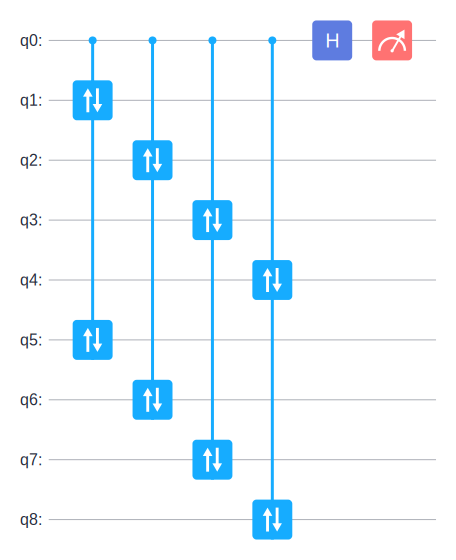

In [51]:
# 搭建广义SWAP Test线路模型
cir_SWAP_Test_gen = Circuit()
cir_SWAP_Test_gen += SWAP.on([1, 5], 0)
cir_SWAP_Test_gen += SWAP.on([2, 6], 0)
cir_SWAP_Test_gen += SWAP.on([3, 7], 0)
cir_SWAP_Test_gen += SWAP.on([4, 8], 0)
cir_SWAP_Test_gen += H.on(0)
cir_SWAP_Test_gen += Measure().on(0)
cir_SWAP_Test_gen.svg()

- 第三步：测量

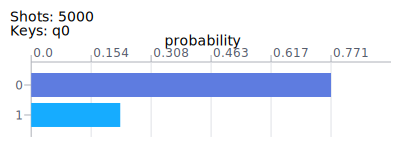

In [53]:
res_16 = sim_16.sampling(cir_SWAP_Test_gen, shots=5000)
res_16.svg()

- 第四步：统计结果，得到欧几里得距离

In [54]:
p_0_fig7 = 3853 / 5000
inner_product_ST_16 = np.sqrt(2 * p_0_fig7 - 1)

print("Fig7中测量第一个量子比特，得到测量为0的频率为：", p_0_fig7)
print("通过Fig7得到的内积<u|v>为：", inner_product_ST_16)

Fig7中测量第一个量子比特，得到测量为0的频率为： 0.7706
通过Fig7得到的内积<u|v>为： 0.7356629663099807


In [55]:
error_inner_16 = (inner_product_ST_16 - inner_product_16) / inner_product_16 * 100

print("通过量子计算的方法计算得到的内积的误差为：", error_inner_16, "%")

通过量子计算的方法计算得到的内积的误差为： 1.0740827170041451 %


In [56]:
D_Euc_ST_16 = np.sqrt(length_u_16**2 + length_v_16**2 - 2 * length_u_16 * length_v_16 * inner_product_ST_16)

print("向量u和向量v的欧几里得距离等于", D_Euc_ST_16)

向量u和向量v的欧几里得距离等于 18.569267509592308


In [57]:
error_D_Euc_16 = (D_Euc_ST_16 - D_Euc_16) / D_Euc_16 * 100

print("通过量子计算的方法计算得到的欧几里得的误差为：", error_D_Euc_16, "%")

通过量子计算的方法计算得到的欧几里得的误差为： -1.44456113038147 %


至此，我们通过MindQuantum成功验证（3）论文中的Fig7可以计算2个16维向量$\vec{u}$和$\vec{v}$的欧几里得距离（即$n=4$的情况）。

### 通过MindQuantum验证（4）论文中的Fig8和Fig10的线路等价性；

要验证线路等价，通常来说有两个方法：要么证明线路对应的酉矩阵相等，要么证明线路对应的真值表相等。

在之前的介绍中，我已经用过第一种方法了，下面来介绍第二种方法——输出量子线路的真值表。

先验证Fig8的线路等价性。

![Fig_8.png](./Fig_8.png)

首先，输出`Fredkin`门的真值表，输入如下代码：

In [58]:
all_inputs = []
for q2 in ['0', '1']:
    for q1 in ['0', '1']:
        for q0 in ['0', '1']:
            all_inputs.append(q2 + q1 + q0)

print('Input:', all_inputs)

print("Initial state ==> Final state")

for _input in all_inputs:
    circuit = Circuit()

    if _input[0] == '1':
         circuit += X.on(2)
    if _input[1] == '1':
        circuit += X.on(1)
    if _input[2] == '1':
        circuit += X.on(0)

    sim = Simulator('mqvector', 3)

    sim.apply_circuit(circuit)
    initial = sim.get_qs(ket=True)

    sim.reset()

    # Fig8中的Fredkin门
    circuit += SWAP.on([1, 2], 0)

    sim.apply_circuit(circuit)
    final = sim.get_qs(ket=True)

    if initial == final:
        print(initial, "==>", final, " (no change)")
    else:
        print(initial, "==>", final, " (Fradkin gate is activated)")

Input: ['000', '001', '010', '011', '100', '101', '110', '111']
Initial state ==> Final state
1¦000⟩ ==> 1¦000⟩  (no change)
1¦001⟩ ==> 1¦001⟩  (no change)
1¦010⟩ ==> 1¦010⟩  (no change)
1¦011⟩ ==> 1¦101⟩  (Fradkin gate is activated)
1¦100⟩ ==> 1¦100⟩  (no change)
1¦101⟩ ==> 1¦011⟩  (Fradkin gate is activated)
1¦110⟩ ==> 1¦110⟩  (no change)
1¦111⟩ ==> 1¦111⟩  (no change)


然后，输出Fig8中等式右端的线路的真值表，输入如下代码：

In [59]:
all_inputs = []
for q2 in ['0', '1']:
    for q1 in ['0', '1']:
        for q0 in ['0', '1']:
            all_inputs.append(q2 + q1 + q0)

print('Input:', all_inputs)

print("Initial state ==> Final state")

for _input in all_inputs:
    circuit = Circuit()

    if _input[0] == '1':
         circuit += X.on(2)
    if _input[1] == '1':
        circuit += X.on(1)
    if _input[2] == '1':
        circuit += X.on(0)

    sim = Simulator('mqvector', 3)

    sim.apply_circuit(circuit)
    initial = sim.get_qs(ket=True)

    sim.reset()

    # Fig8中等式右端的量子线路
    circuit += X.on(2, 1)
    circuit += X.on(1, [0, 2])
    circuit += X.on(2, 1)

    sim.apply_circuit(circuit)
    final = sim.get_qs(ket=True)

    if initial == final:
        print(initial, "==>", final, " (no change)")
    else:
        print(initial, "==>", final, " (construction of Fredkin is activated)")

Input: ['000', '001', '010', '011', '100', '101', '110', '111']
Initial state ==> Final state
1¦000⟩ ==> 1¦000⟩  (no change)
1¦001⟩ ==> 1¦001⟩  (no change)
1¦010⟩ ==> 1¦010⟩  (no change)
1¦011⟩ ==> 1¦101⟩  (construction of Fredkin is activated)
1¦100⟩ ==> 1¦100⟩  (no change)
1¦101⟩ ==> 1¦011⟩  (construction of Fredkin is activated)
1¦110⟩ ==> 1¦110⟩  (no change)
1¦111⟩ ==> 1¦111⟩  (no change)


可以看到，2个线路对应的真值表，它们的作用效果，都是使得1¦011⟩ ==> 1¦101⟩以及1¦101⟩ ==> 1¦011⟩，而其它保持不变，因此可以得证Fig8的线路等价性。

![Fig_10.png](./Fig_10.png)

我用同样的方法输出Fig10中等式两端的线路的真值表。

In [60]:
all_inputs = []
for q1 in ['0', '1']:
    for q0 in ['0', '1']:
        all_inputs.append(q1 + q0)

print('Input:', all_inputs)

print("Initial state ==> Final state")

for _input in all_inputs:
    circuit = Circuit()

    if _input[0] == '1':
        circuit += X.on(1)
    if _input[1] == '1':
        circuit += X.on(0)

    sim2 = Simulator('mqvector', 2)

    sim2.apply_circuit(circuit)
    initial = sim2.get_qs(ket=True)

    sim2.reset()

    # Fig10中的CZ门
    circuit += Z.on(1, 0)

    sim2.apply_circuit(circuit)
    final = sim2.get_qs(ket=True)

    if initial == final:
        print(initial, "==>", final, " (no change)")
    else:
        print(initial, "==>", final, " (CZ is activated)")

Input: ['00', '01', '10', '11']
Initial state ==> Final state
1¦00⟩ ==> 1¦00⟩  (no change)
1¦01⟩ ==> 1¦01⟩  (no change)
1¦10⟩ ==> 1¦10⟩  (no change)
1¦11⟩ ==> -1¦11⟩  (CZ is activated)


In [62]:
all_inputs = []
for q1 in ['0', '1']:
    for q0 in ['0', '1']:
        all_inputs.append(q1 + q0)

print('Input:', all_inputs)

print("Initial state ==> Final state")

for _input in all_inputs:
    circuit = Circuit()

    if _input[0] == '1':
        circuit += X.on(1)
    if _input[1] == '1': 
        circuit += X.on(0)

    sim2 = Simulator('mqvector', 2)

    sim2.apply_circuit(circuit)
    initial = sim2.get_qs(ket=True)

    sim2.reset()

    # Fig10中等式右端的量子线路
    circuit += H.on(1)
    circuit += X.on(1, 0)
    circuit += H.on(1)
    
    sim2.apply_circuit(circuit)
    final = sim2.get_qs(ket=True)

    if initial == final: 
        print(initial, "==>", final, " (no change)")
    else: 
        print(initial, "==>", final, " (construction of CZ is activated)")

Input: ['00', '01', '10', '11']
Initial state ==> Final state
1¦00⟩ ==> 1¦00⟩  (no change)
1¦01⟩ ==> 1¦01⟩  (no change)
1¦10⟩ ==> 1¦10⟩  (no change)
1¦11⟩ ==> -1¦11⟩  (construction of CZ is activated)


可以看到，2个线路对应的真值表，它们的作用效果，都是使得1¦11⟩ ==> -1¦11⟩，而其它保持不变，因此可以得证Fig10的线路等价性。

至此，我们通过MindQuantum成功验证（4）论文中的Fig8和Fig10的线路等价性。

### 通过MindQuantum验证（5）论文中的Fig11的线路正确性；

![Fig_11.png](./Fig_11.png)

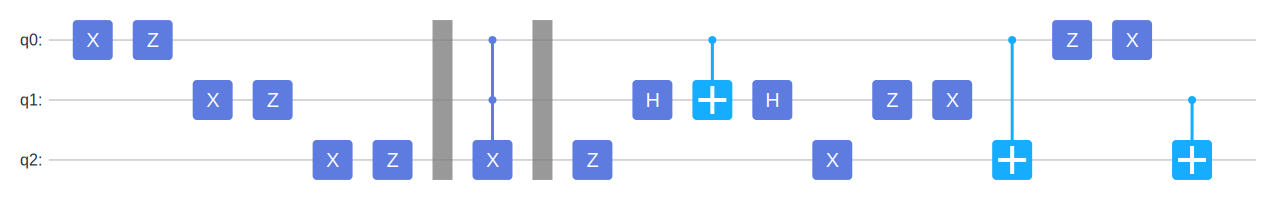

In [61]:
# 为了便于复现，设定生成随机数的种子53，展示随机数全为1的情况，实际过程可以去掉该种子设定
random.seed(53)

Toffoli_encoder_fig11(2, [0, 1]).svg()

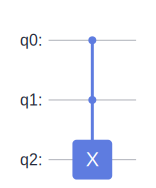

In [62]:
# 搭建一个包含Toffoli门的量子线路
circuit_Toffoli_fig11 = Circuit()
circuit_Toffoli_fig11 += X.on(2, [0, 1])
circuit_Toffoli_fig11.svg()

In [63]:
# 验证上述两个量子线路等价
random.seed(53)

if np.allclose(Toffoli_encoder_fig11(2, [0, 1]).matrix(), circuit_Toffoli_fig11.matrix()) == True:
    print("上述两个量子线路等价")
else:
    print("上述两个量子线路不等")

上述两个量子线路等价


更一般地，验证`Toffoli_encoder_fig11(2, [0, 1])`的量子线路与包含`Toffoli`门的量子线路的等价性。

In [64]:
# 初始化变量
verify_Toffoli_fig11 = 0

# 重复验证100次
for i in range(100):
    # Toffoli_encoder_fig11(2, [0, 1])没有设定seed，因此每次产生的随机数都不一样
    if np.allclose(Toffoli_encoder_fig11(2, [0, 1]).matrix(), circuit_Toffoli_fig11.matrix()) == True:
        verify_Toffoli_fig11 += 1
    else:
        verify_Toffoli_fig11 += 0

if verify_Toffoli_fig11 == 100:
    print("Toffoli_encoder_fig11(2, [0, 1])的量子线路与包含Toffoli门的量子线路等价")
else:
    print("Toffoli_encoder_fig11(2, [0, 1])的量子线路与包含Toffoli门的量子线路不等")

Toffoli_encoder_fig11(2, [0, 1])的量子线路与包含Toffoli门的量子线路等价


也就是说，我们通过MindQuantum成功复现Fig11，并验证该线路的正确性。

至此，我们通过MindQuantum验证（5）论文中的Fig11的线路正确性。

### 通过MindQuantum验证（6）论文中的Fig12（$n=4$的情况），即在Fig7的基础上保密计算2个16维向量$\vec{u}$和$\vec{v}$的欧几里得距离。

首先，我们先简单回顾一下Fig7中2个16维向量的$\vec{u}$和$\vec{v}$的相关已知条件。

In [65]:
print("向量u为", u_16, "，向量v为", v_16)

向量u为 [ 5  6  8  6  1  6  4  8 10  1  8  5  1  0  8 10] ，向量v为 [ 8 10  8  2  6  8  1  8  3  5  3  6  7  9  0  8]


In [66]:
print("向量u的模长为", length_u_16, "，向量v的模长为", length_v_16)

向量u的模长为 25.15949125081825 ，向量v的模长为 25.88435821108957


In [67]:
print("归一化后的向量u为", u_nor_16, "，\n归一化后的向量v为", v_nor_16)

归一化后的向量u为 [0.19873216 0.23847859 0.31797145 0.23847859 0.03974643 0.23847859
 0.15898573 0.31797145 0.39746432 0.03974643 0.31797145 0.19873216
 0.03974643 0.         0.31797145 0.39746432] ，
归一化后的向量v为 [0.30906696 0.3863337  0.30906696 0.07726674 0.23180022 0.30906696
 0.03863337 0.30906696 0.11590011 0.19316685 0.11590011 0.23180022
 0.27043359 0.34770033 0.         0.30906696]


In [68]:
print("归一化的向量u和向量v的内积等于", inner_product_16)

归一化的向量u和向量v的内积等于 0.7278453056751975


In [69]:
print("向量u和向量v的欧几里得距离等于", D_Euc_16)

向量u和向量v的欧几里得距离等于 18.84144368141677


![Fig_12.png](./Fig_12.png)

- 第一步：初态制备

In [70]:
# 归一化的向量u和向量v的张量积
# 注意，越靠上的量子比特，做张量积的时候越靠右，因为MindQuantum的读取顺序是从右往左
pre_fig12 = np.kron(v_nor_16, u_nor_16)

print("归一化的向量u和向量v的张量积为", pre_fig12)

归一化的向量u和向量v的张量积为 [0.06142154 0.07370585 0.09827447 0.07370585 0.01228431 0.07370585
 0.04913724 0.09827447 0.12284309 0.01228431 0.09827447 0.06142154
 0.01228431 0.         0.09827447 0.12284309 0.07677693 0.09213232
 0.12284309 0.09213232 0.01535539 0.09213232 0.06142154 0.12284309
 0.15355386 0.01535539 0.12284309 0.07677693 0.01535539 0.
 0.12284309 0.15355386 0.06142154 0.07370585 0.09827447 0.07370585
 0.01228431 0.07370585 0.04913724 0.09827447 0.12284309 0.01228431
 0.09827447 0.06142154 0.01228431 0.         0.09827447 0.12284309
 0.01535539 0.01842646 0.02456862 0.01842646 0.00307108 0.01842646
 0.01228431 0.02456862 0.03071077 0.00307108 0.02456862 0.01535539
 0.00307108 0.         0.02456862 0.03071077 0.04606616 0.05527939
 0.07370585 0.05527939 0.00921323 0.05527939 0.03685293 0.07370585
 0.09213232 0.00921323 0.07370585 0.04606616 0.00921323 0.
 0.07370585 0.09213232 0.06142154 0.07370585 0.09827447 0.07370585
 0.01228431 0.07370585 0.04913724 0.09827447 0.12284309 0.012

In [71]:
# |+>态对应的向量
state_plus = 1 / np.sqrt(2) * np.array([1, 1])

print("|+>态对应的向量为", state_plus)

|+>态对应的向量为 [0.70710678 0.70710678]


In [72]:
# 制备初态，分两部分，前半部分
initial_state_first = np.kron(pre_fig12, state_plus)

print("前半部分的初态对应的向量为", initial_state_first)

前半部分的初态对应的向量为 [0.04343159 0.04343159 0.05211791 0.05211791 0.06949055 0.06949055
 0.05211791 0.05211791 0.00868632 0.00868632 0.05211791 0.05211791
 0.03474527 0.03474527 0.06949055 0.06949055 0.08686318 0.08686318
 0.00868632 0.00868632 0.06949055 0.06949055 0.04343159 0.04343159
 0.00868632 0.00868632 0.         0.         0.06949055 0.06949055
 0.08686318 0.08686318 0.05428949 0.05428949 0.06514739 0.06514739
 0.08686318 0.08686318 0.06514739 0.06514739 0.0108579  0.0108579
 0.06514739 0.06514739 0.04343159 0.04343159 0.08686318 0.08686318
 0.10857898 0.10857898 0.0108579  0.0108579  0.08686318 0.08686318
 0.05428949 0.05428949 0.0108579  0.0108579  0.         0.
 0.08686318 0.08686318 0.10857898 0.10857898 0.04343159 0.04343159
 0.05211791 0.05211791 0.06949055 0.06949055 0.05211791 0.05211791
 0.00868632 0.00868632 0.05211791 0.05211791 0.03474527 0.03474527
 0.06949055 0.06949055 0.08686318 0.08686318 0.00868632 0.00868632
 0.06949055 0.06949055 0.04343159 0.04343159 0.00868632 0

In [73]:
# |0>态对应的向量
state_0 = np.array([1, 0])

print("|0>态对应的向量为", state_0)

|0>态对应的向量为 [1 0]


In [74]:
# 制备初态，分两部分，后半部分，辅助比特
initial_state_second = np.kron(np.kron(state_0, state_0), state_0)

print("后半部分的初态对应的向量为", initial_state_second)

后半部分的初态对应的向量为 [1 0 0 0 0 0 0 0]


In [75]:
initial_state_fig12 = np.kron(initial_state_second, initial_state_first)

print("完整的初态对应的向量为", initial_state_fig12)

完整的初态对应的向量为 [0.04343159 0.04343159 0.05211791 ... 0.         0.         0.        ]


In [76]:
sim_fig12 = Simulator('mqvector', 12)     # 调用一个12量子比特的模拟器
sim_fig12.set_qs(initial_state_fig12)     # 将模拟器的初态设为与initial_state_fig12对应的量子态

print(sim_fig12.get_qs(True))             # 打印我们制备好的初态

0.04343159082681246¦000000000000⟩
0.04343159082681246¦000000000001⟩
0.052117908992174944¦000000000010⟩
0.052117908992174944¦000000000011⟩
0.06949054532289994¦000000000100⟩
0.06949054532289994¦000000000101⟩
0.052117908992174944¦000000000110⟩
0.052117908992174944¦000000000111⟩
0.008686318165362493¦000000001000⟩
0.008686318165362493¦000000001001⟩
0.052117908992174944¦000000001010⟩
0.052117908992174944¦000000001011⟩
0.03474527266144997¦000000001100⟩
0.03474527266144997¦000000001101⟩
0.06949054532289994¦000000001110⟩
0.06949054532289994¦000000001111⟩
0.08686318165362492¦000000010000⟩
0.08686318165362492¦000000010001⟩
0.008686318165362493¦000000010010⟩
0.008686318165362493¦000000010011⟩
0.06949054532289994¦000000010100⟩
0.06949054532289994¦000000010101⟩
0.04343159082681246¦000000010110⟩
0.04343159082681246¦000000010111⟩
0.008686318165362493¦000000011000⟩
0.008686318165362493¦000000011001⟩
0.06949054532289994¦000000011100⟩
0.06949054532289994¦000000011101⟩
0.08686318165362492¦000000011110⟩
0.

- 第二步：广义SWAP Test

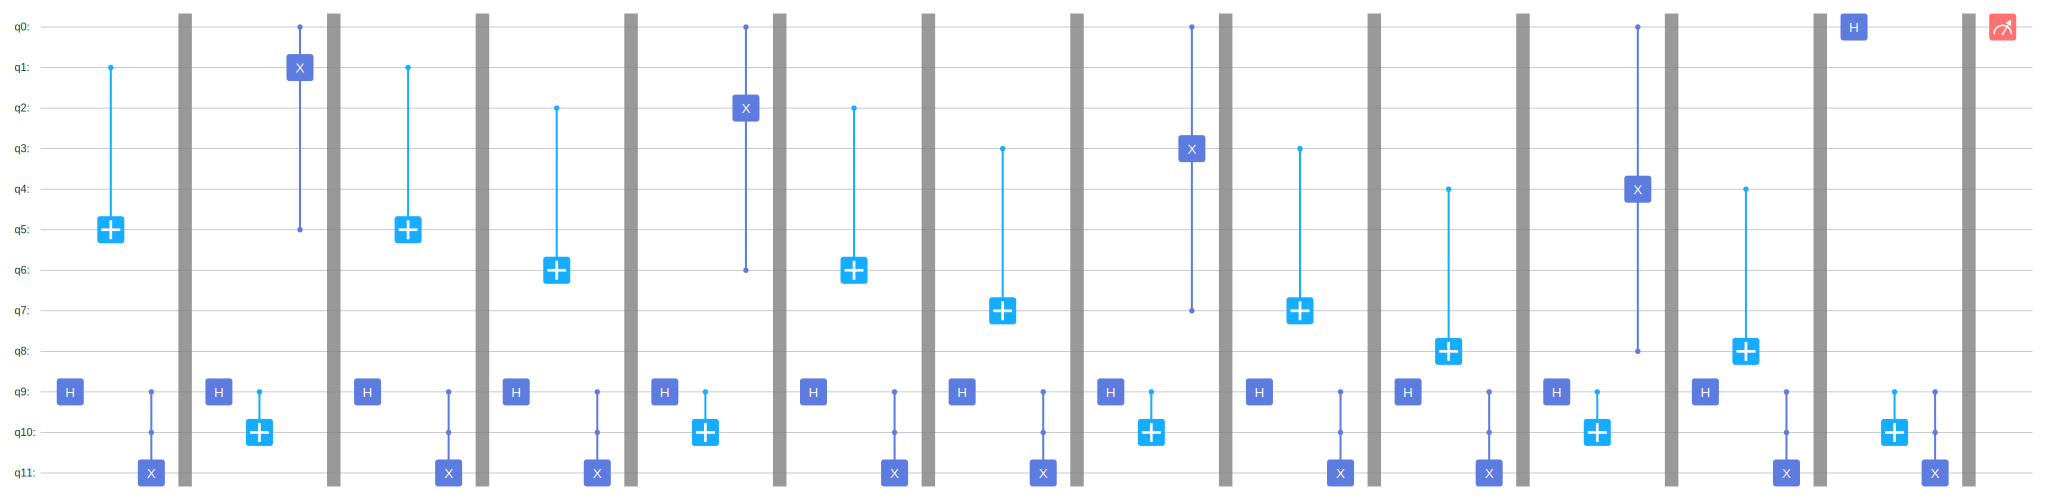

In [77]:
# 搭建广义SWAP Test线路模型
cir_SWAP_Test_gen_fig12 = Circuit()

# 第一次执行Fredkin门
cir_SWAP_Test_gen_fig12 += H.on(9)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(5, 1)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(11, [9, 10])
cir_SWAP_Test_gen_fig12 += BarrierGate(True)

cir_SWAP_Test_gen_fig12 += H.on(9)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(10, 9)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(1, [0, 5])
cir_SWAP_Test_gen_fig12 += BarrierGate(True)

cir_SWAP_Test_gen_fig12 += H.on(9)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(5, 1)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(11, [9, 10])
cir_SWAP_Test_gen_fig12 += BarrierGate(True)

# 第二次执行Fredkin门
cir_SWAP_Test_gen_fig12 += H.on(9)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(6, 2)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(11, [9, 10])
cir_SWAP_Test_gen_fig12 += BarrierGate(True)

cir_SWAP_Test_gen_fig12 += H.on(9)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(10, 9)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(2, [0, 6])
cir_SWAP_Test_gen_fig12 += BarrierGate(True)

cir_SWAP_Test_gen_fig12 += H.on(9)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(6, 2)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(11, [9, 10])
cir_SWAP_Test_gen_fig12 += BarrierGate(True)

# 第三次执行Fredkin门
cir_SWAP_Test_gen_fig12 += H.on(9)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(7, 3)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(11, [9, 10])
cir_SWAP_Test_gen_fig12 += BarrierGate(True)

cir_SWAP_Test_gen_fig12 += H.on(9)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(10, 9)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(3, [0, 7])
cir_SWAP_Test_gen_fig12 += BarrierGate(True)

cir_SWAP_Test_gen_fig12 += H.on(9)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(7, 3)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(11, [9, 10])
cir_SWAP_Test_gen_fig12 += BarrierGate(True)

# 第四次执行Fredkin门
cir_SWAP_Test_gen_fig12 += H.on(9)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(8, 4)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(11, [9, 10])
cir_SWAP_Test_gen_fig12 += BarrierGate(True)

cir_SWAP_Test_gen_fig12 += H.on(9)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(10, 9)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(4, [0, 8])
cir_SWAP_Test_gen_fig12 += BarrierGate(True)

cir_SWAP_Test_gen_fig12 += H.on(9)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(8, 4)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(11, [9, 10])
cir_SWAP_Test_gen_fig12 += BarrierGate(True)

# 执行H门
cir_SWAP_Test_gen_fig12 += H.on(0)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(10, 9)
cir_SWAP_Test_gen_fig12 += BARRIER
cir_SWAP_Test_gen_fig12 += X.on(11, [9, 10])
cir_SWAP_Test_gen_fig12 += BarrierGate(True)

# 测量第一个量子比特
cir_SWAP_Test_gen_fig12 += Measure().on(0)

cir_SWAP_Test_gen_fig12.svg()

- 第三步：测量

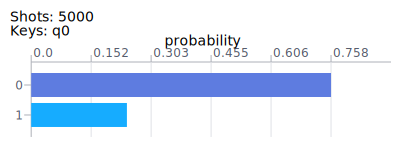

In [78]:
res_fig12 = sim_fig12.sampling(cir_SWAP_Test_gen_fig12, shots=5000)
res_fig12.svg()

- 第四步：统计结果，得到欧几里得距离

从上述sampling的结果可以看到，得到0的次数为3853次，与Fig7得到的结果完全一致，因此后续的计算可以得到与Fig7完全相等的结果。

In [79]:
p_0_fig12 = 3853 / 5000
inner_product_ST_fig12 = np.sqrt(2 * p_0_fig12 - 1)

print("Fig12中测量第一个量子比特，得到测量为0的频率为：", p_0_fig12)
print("通过Fig12得到的内积<u|v>为：", inner_product_ST_fig12)

Fig12中测量第一个量子比特，得到测量为0的频率为： 0.7706
通过Fig12得到的内积<u|v>为： 0.7356629663099807


In [80]:
error_inner_fig12 = (inner_product_ST_fig12 - inner_product_16) / inner_product_16 * 100

print("通过量子计算的方法计算得到的内积的误差为：", error_inner_fig12, "%")

通过量子计算的方法计算得到的内积的误差为： 1.0740827170041451 %


In [81]:
D_Euc_ST_fig12 = np.sqrt(length_u_16**2 + length_v_16**2 - 2 * length_u_16 * length_v_16 * inner_product_ST_fig12)

print("向量u和向量v的欧几里得距离等于", D_Euc_ST_fig12)

向量u和向量v的欧几里得距离等于 18.569267509592308


In [82]:
error_D_Euc_fig12 = (D_Euc_ST_fig12 - D_Euc_16) / D_Euc_16 * 100

print("通过量子计算的方法计算得到的欧几里得的误差为：", error_D_Euc_fig12, "%")

通过量子计算的方法计算得到的欧几里得的误差为： -1.44456113038147 %


再次验证，我们得到与Fig7完全相等的结果。

至此，我们通过MindQuantum成功验证（6）论文中的Fig12（$n=4$的情况），即在Fig7的基础上保密计算2个16维向量$\vec{u}$和$\vec{v}$的欧几里得距离。

## 项目总结

### 复现的论文&复现结果

我复现的是2021年11月1日在《Quantum Information Processing》上发表的论文，文章题目为“Blind quantum machine learning based on quantum circuit model”，文章作者为Xu Zhou和Daowen Qiu。

我通过MindQuantum复现了文章中的Fig1-Fig12，并验证了每个线路设计的正确性，详细见文中提到的复现目标。

### 创新点

在复现过程中，我的创新点如下：

（1）利用MindQuantum首次复现盲量子计算相关的论文；

（2）利用到了MindQuantum最新的功能，输出量子线路矩阵的matrix()功能，并把发现的问题在主仓中提了issue；

（3）利用到了np.kron()计算向量外积，再在模拟器上set_qs()的功能来制备线路的初态，而一般我们量子线路的初态为全|0>态；

（4）利用MindQuantum实现输出量子线路真值表的功能；

（5）华为bbs论坛的复现要求：验证论文中的Fig2，Fig3，Fig4，Fig5，Fig6，Fig9，Fig11中线路的正确性，复现论文中最终的Fig12中n=4的情况。在完成复现要求的基础上，我把剩下的Fig1，Fig7，Fig8，Fig10也复现了，并给出了证明，使得整个复现工作比较完整。

### 未来可继续研究的方向

（1）目前该论文限定了向量为实且非负的，后续可以考虑复向量的欧几里得距离的计算；

（2）目前该论文还只是计算两个向量间的欧几里得距离，后续可以通过叠加态的形式，同时计算多个量子态间的距离；

（3）目前该论文考虑的是理想信道下的量子计算，后续可以考虑在含噪声的量子信道上完成该任务；

（4）目前该论文只完成量子机器学习中的某一步，计算欧几里得距离，后续可以加入到具体的量子机器学习任务中，从而展示量子计算的强大计算优势。